In [67]:
library(SingleCellExperiment)
library(Seurat)
library(mclust)
library(dplyr)

In [69]:
umi <- readRDS("after_feat_sel.rds")

# Change labels for genes of interest
name_map = list(
    ENSMUSG00000062327 = "Brachyury",
    ENSMUSG00000032446 = "Eomes",
    ENSMUSG00000030544 = "Mesp1",
    ENSMUSG00000024406 = "Pou5f1",
    ENSMUSG00000012396 = "nanog",
    ENSMUSG00000096014 = "Sox1",
    ENSMUSG00000074637 = "Sox2",
    ENSMUSG00000090125 = "Pou3f1",
    ENSMUSG00000060206 = "zfp462",
    ENSMUSG00000031297 = "slc7a3"
)

for (i in 1:length(name_map)){
    old_gene_name <- names(name_map[i])
    new_gene_name <- name_map[[i]]
    #message(old_gene_name, "→", new_gene_name)
    rownames(umi)[which(rownames(umi) == old_gene_name)] <- new_gene_name
}

seuset <- CreateSeuratObject(
    raw.data = counts(umi),
    min.cells = 3, 
    min.genes = 200
)

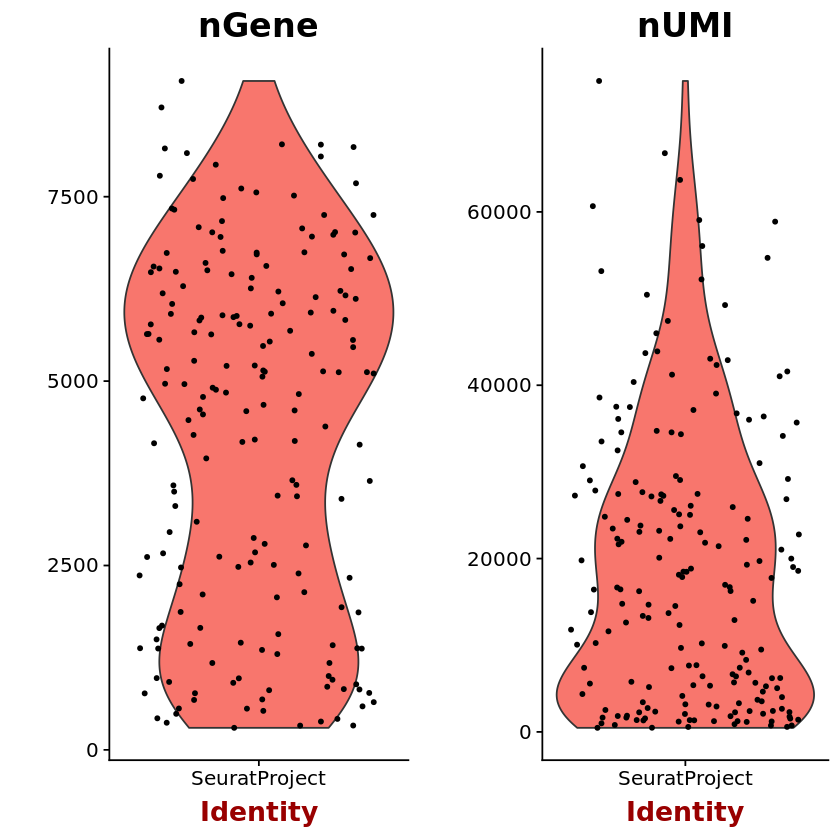

In [70]:
VlnPlot(
    object = seuset, 
    features.plot = c("nGene", "nUMI"), 
    nCol = 2
)

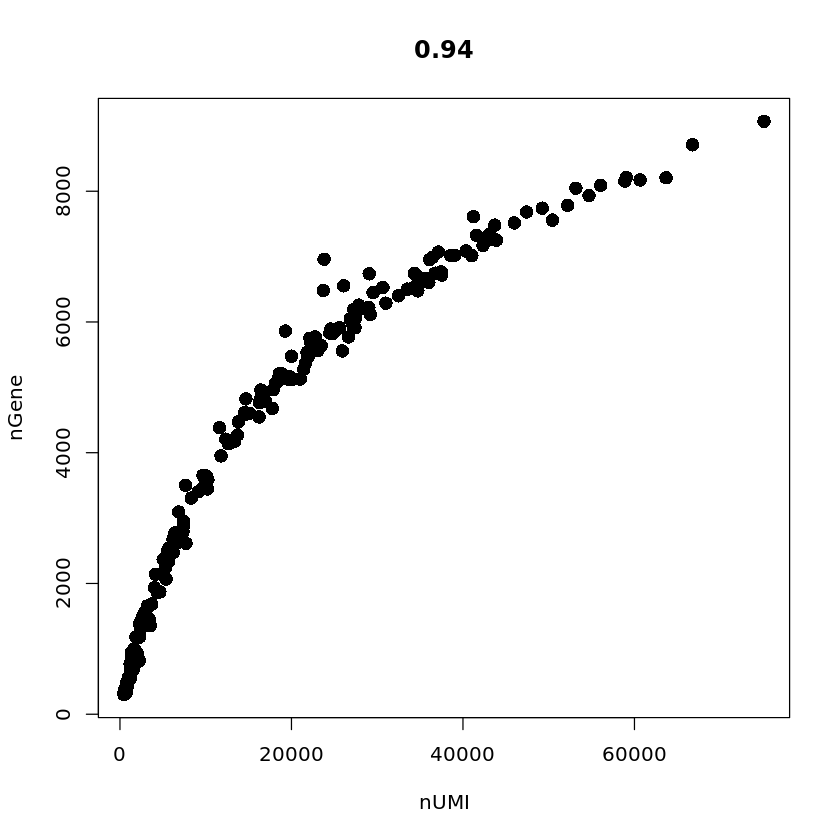

In [71]:
GenePlot(
    object = seuset, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

In [103]:
seuset <- FilterCells(
    object = seuset, 
    subset.names = c("nUMI"), #, "nGene"), 
    #low.thresholds = c(1, -Inf),
    high.thresholds = c(2e7) #, Inf)
)

In [104]:
# normalise
seuset <- NormalizeData(
    object = seuset, 
    normalization.method = "LogNormalize", 
    scale.factor = 10000
)

[1] 2297

The average expression and dispersion of each gene


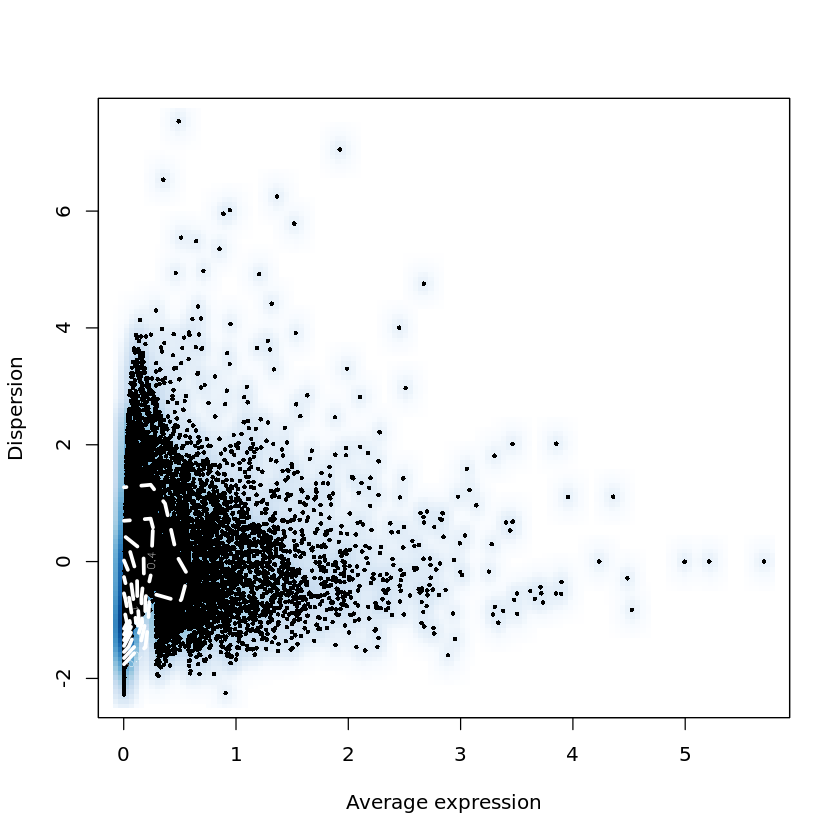

In [105]:
# HVG
seuset <- FindVariableGenes(
    object = seuset,
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, 
    x.high.cutoff = 3, 
    y.cutoff = 1,
    do.text = FALSE
)
length(x = seuset@var.genes)
message("The average expression and dispersion of each gene")

In [106]:
# Confounders
seuset <- ScaleData(
    object = seuset, 
    vars.to.regress = c("nUMI")
)

[1] "Regressing out nUMI"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


In [108]:
# Linear dim reduction
seuset <- RunPCA(
    object = seuset, 
    pc.genes = seuset@var.genes, 
    do.print = FALSE, 
    pcs.print = 1:6, 
    genes.print = 5
)
#PrintPCA(object = seuset, pcs.print = 1:6, genes.print = 5, use.full = FALSE)

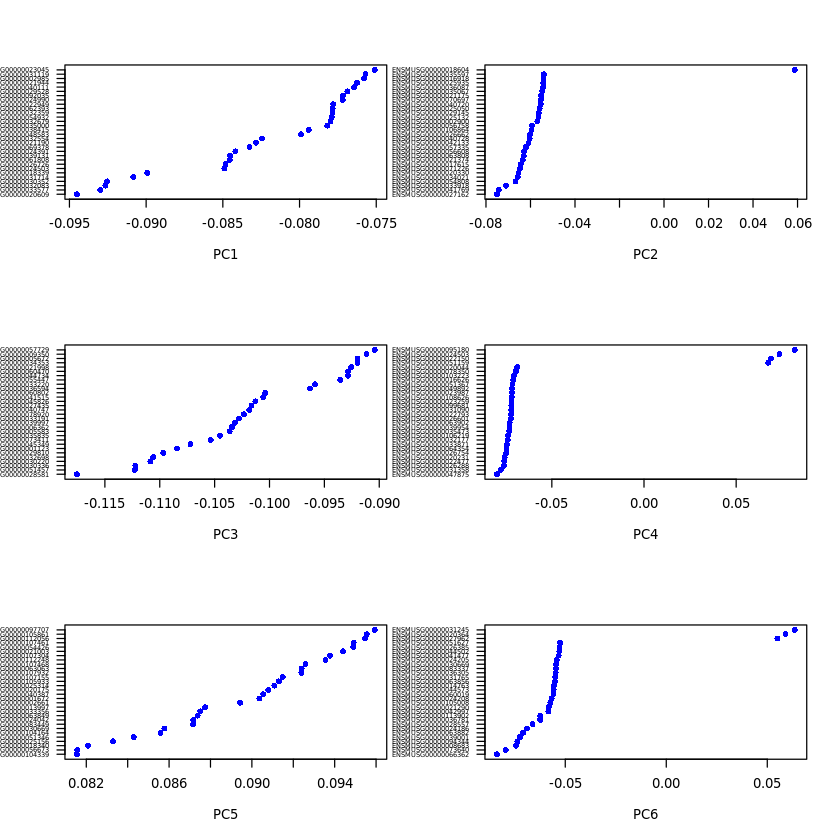

In [109]:
VizPCA(object = seuset, pcs.use = 1:6)

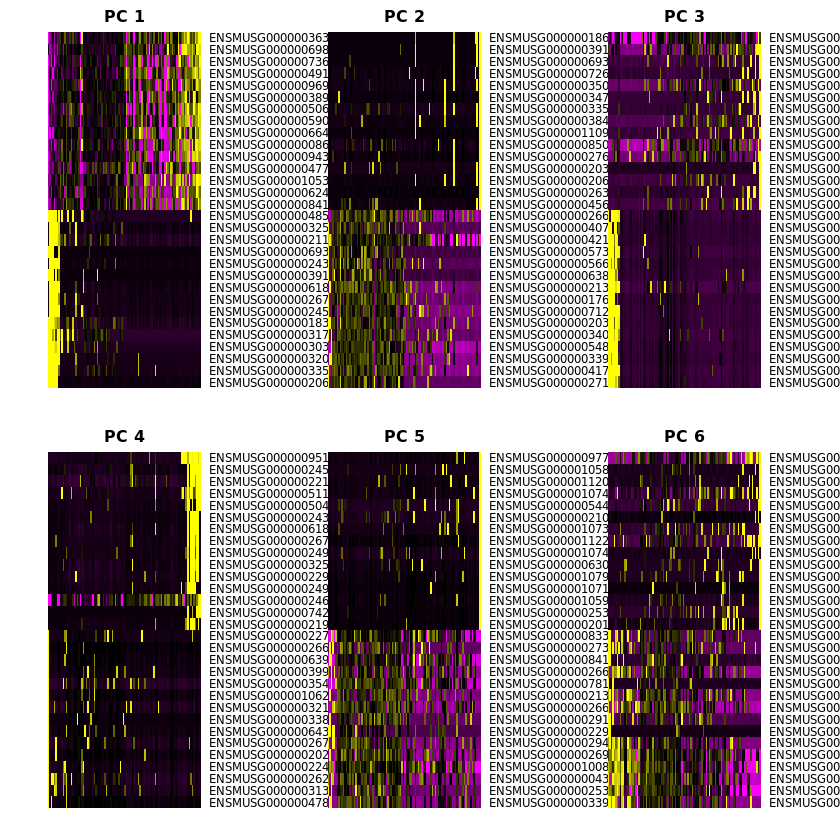

In [110]:
PCHeatmap(
    object = seuset, 
    pc.use = 1:6, 
    cells.use = 100, 
    do.balanced = TRUE, 
    label.columns = FALSE,
    use.full = FALSE
)

In [111]:
seuset <- JackStraw(
    object = seuset, 
    num.replicate = 100, 
    do.print = FALSE
)

Warning message:
“Removed 30620 rows containing missing values (geom_point).”

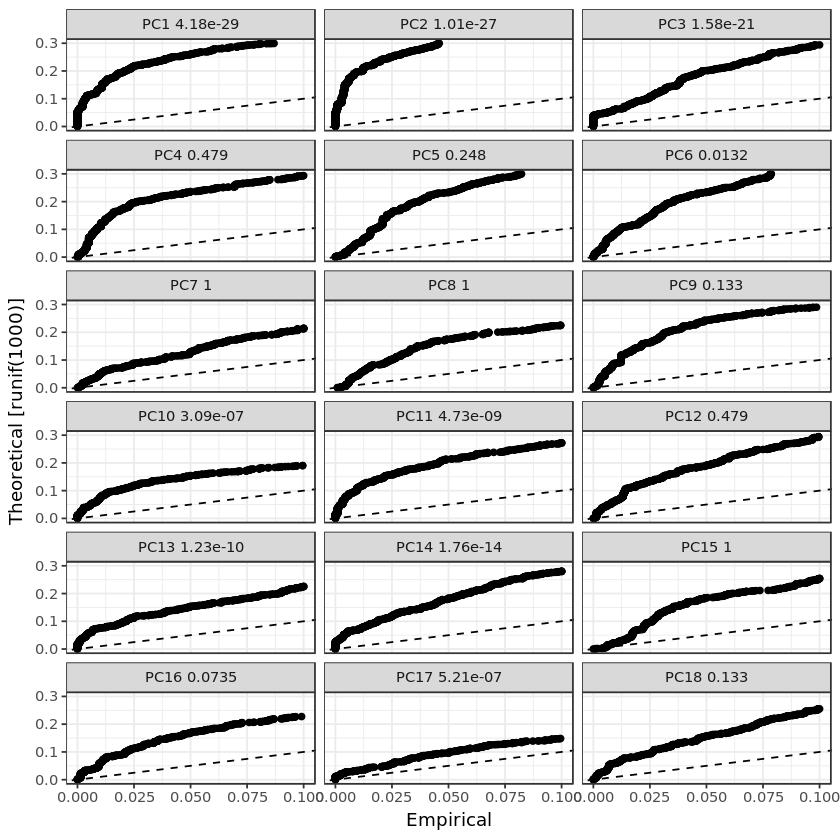

In [112]:
JackStrawPlot(object = seuset, PCs = 1:18)

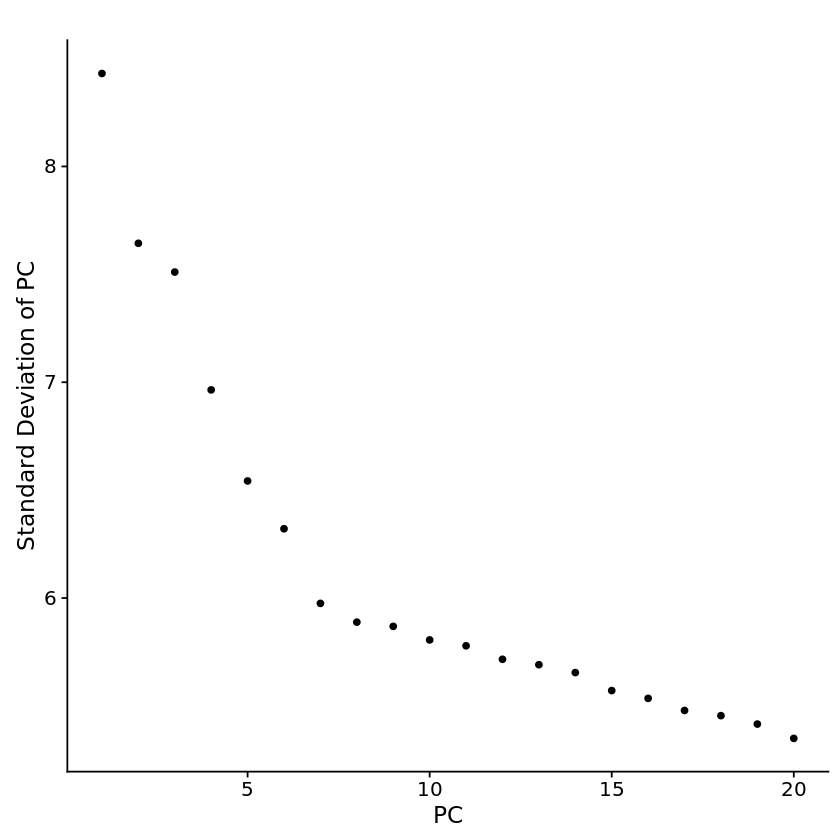

In [113]:
PCElbowPlot(object = seuset)

In [148]:
# Clustering
seuset <- FindClusters(
    object = seuset, 
    reduction.type = "pca",   # tsne, 1:2, yields 4
    dims.use = 1:6,            # 1:10 yields 4
    resolution = 1.0, 
    print.output = 0,
    save.SNN = TRUE,
    temp.file = "/extra/",
    force.recalc = TRUE
)
PrintFindClustersParams(object = seuset)
table(seuset@ident)

Parameters used in latest FindClusters calculation run on: 2018-01-29 01:27:10
Resolution: 1
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6




 0  1  2 
67 67 56 

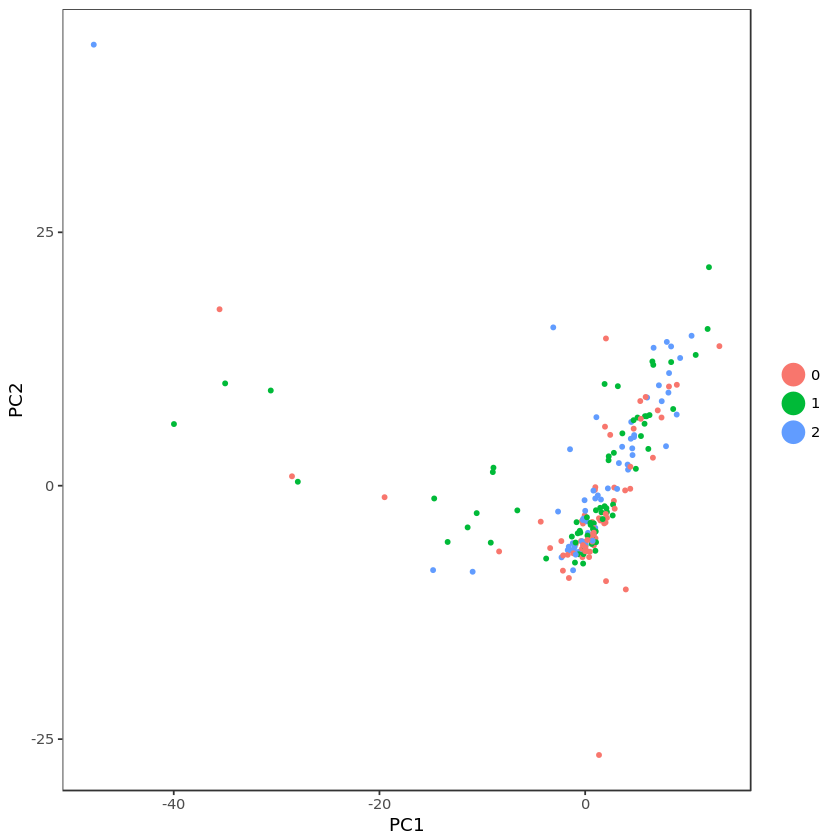

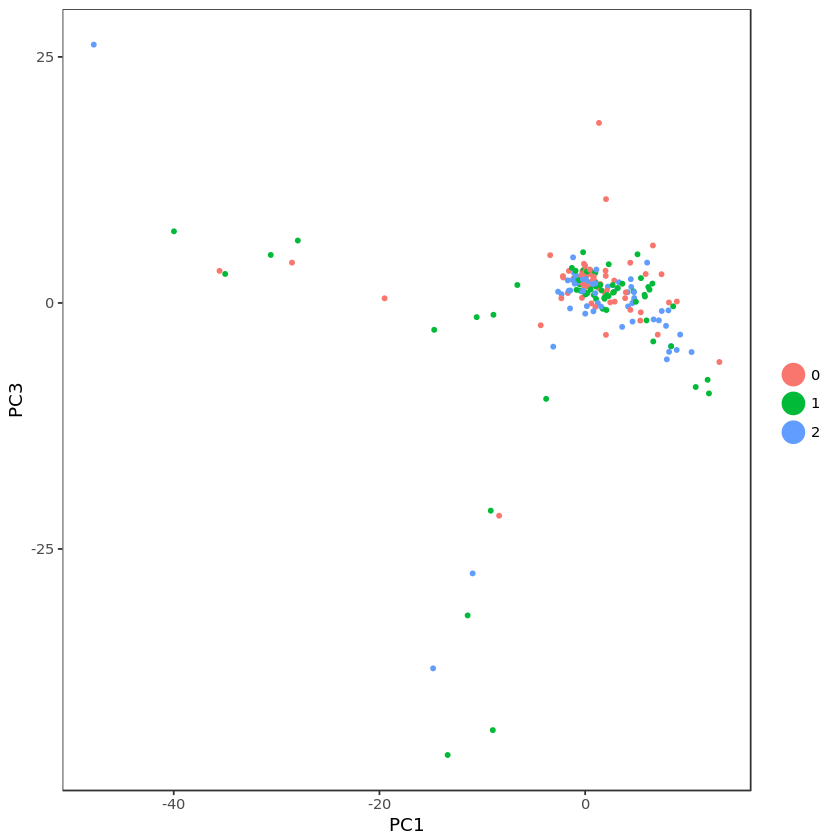

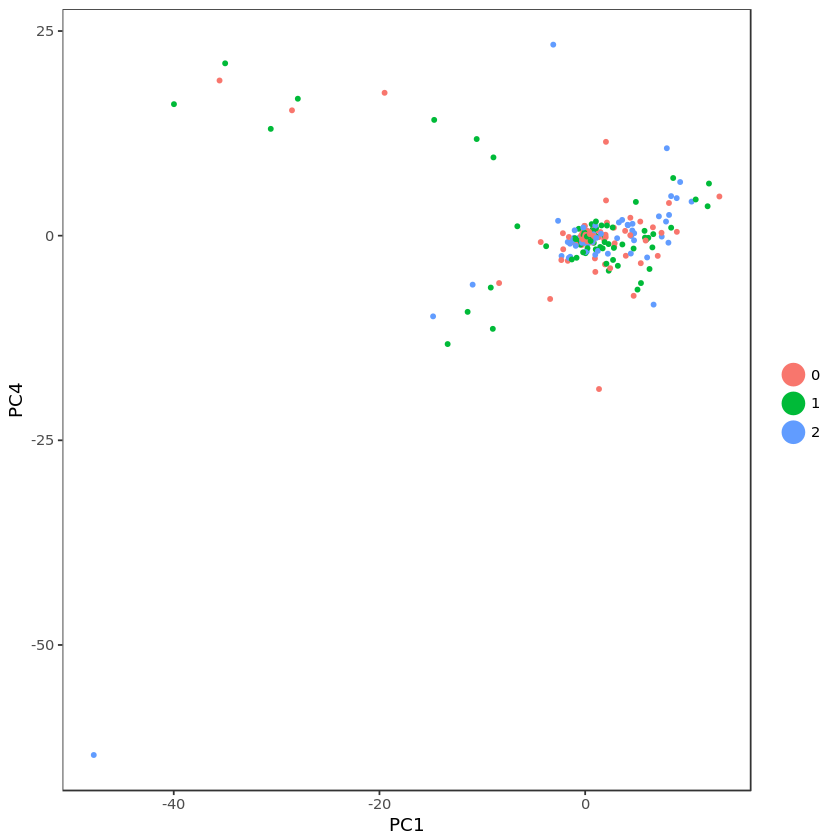

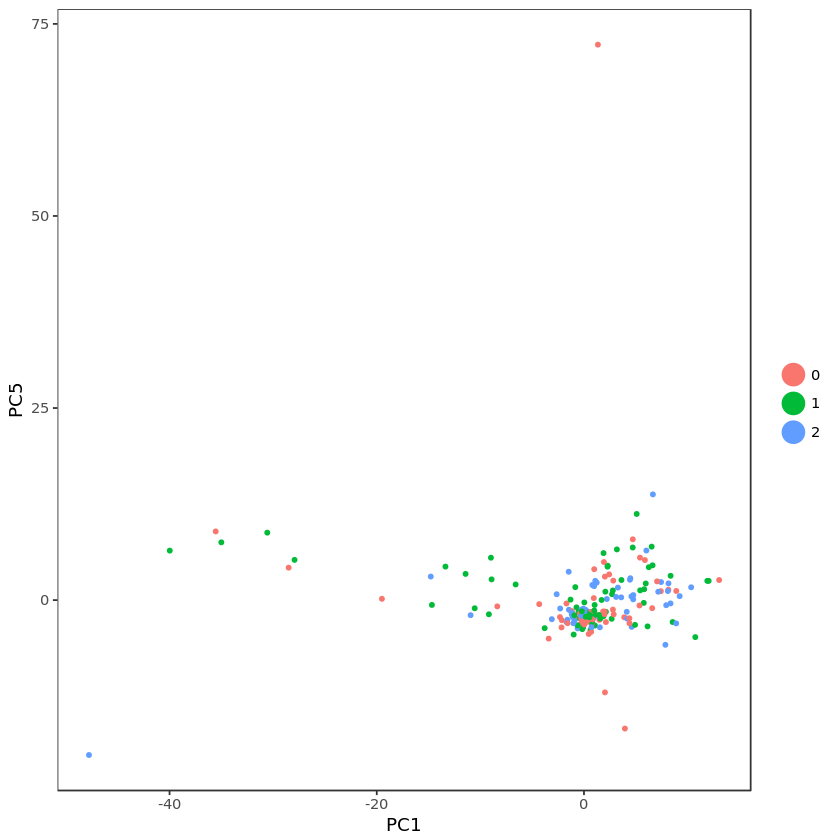

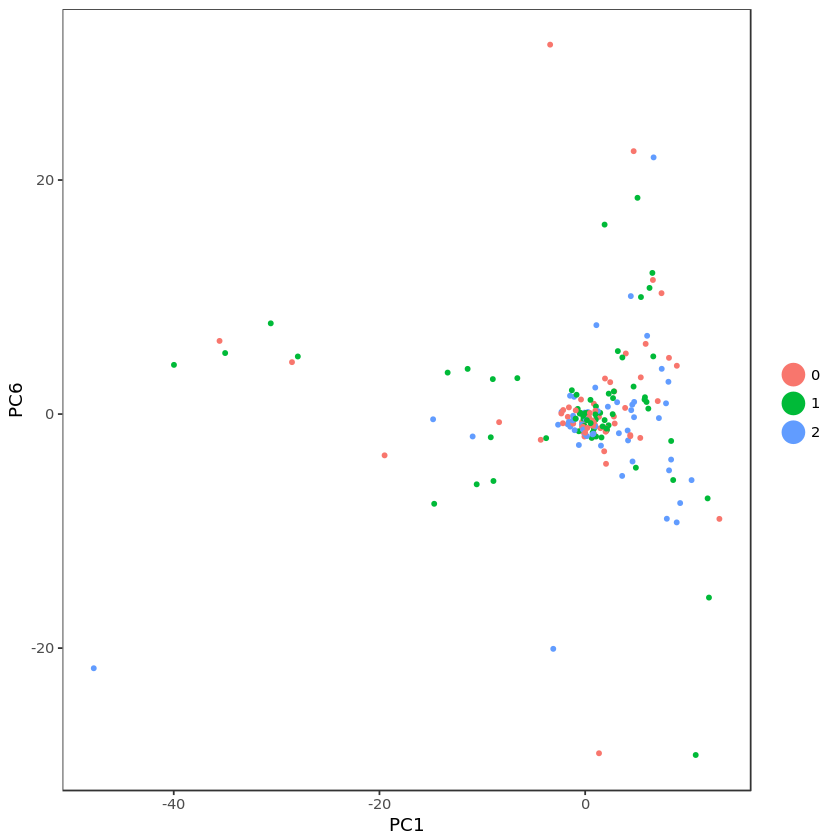

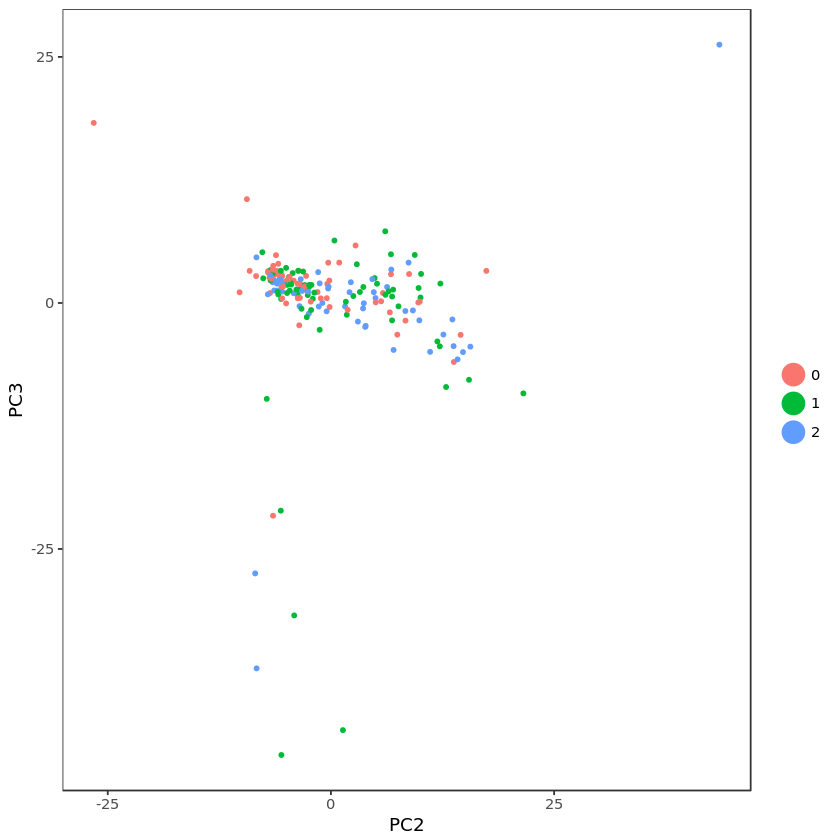

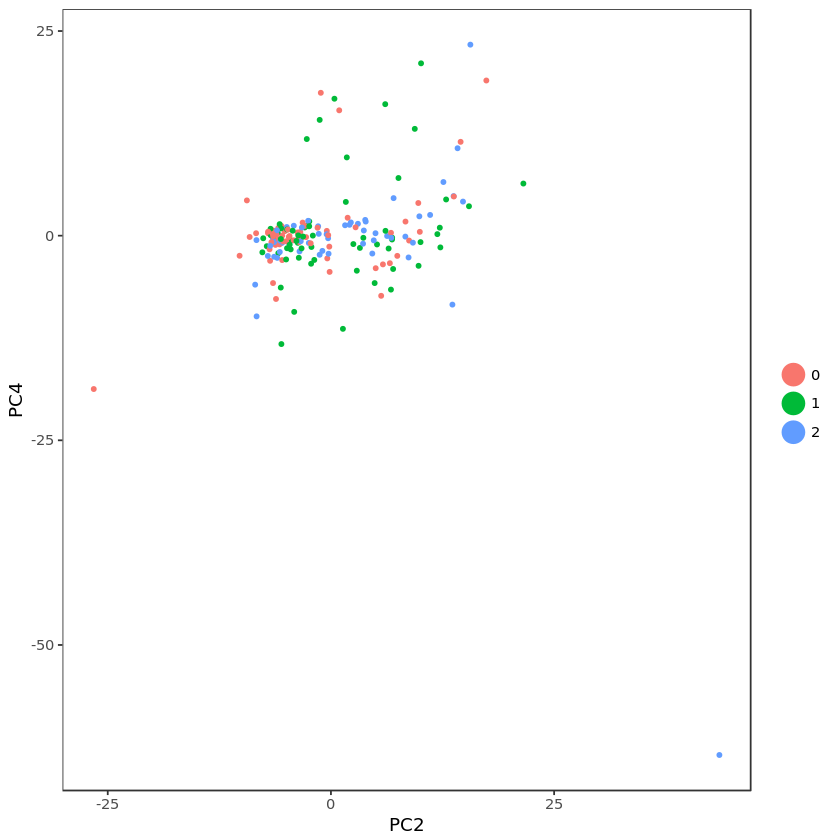

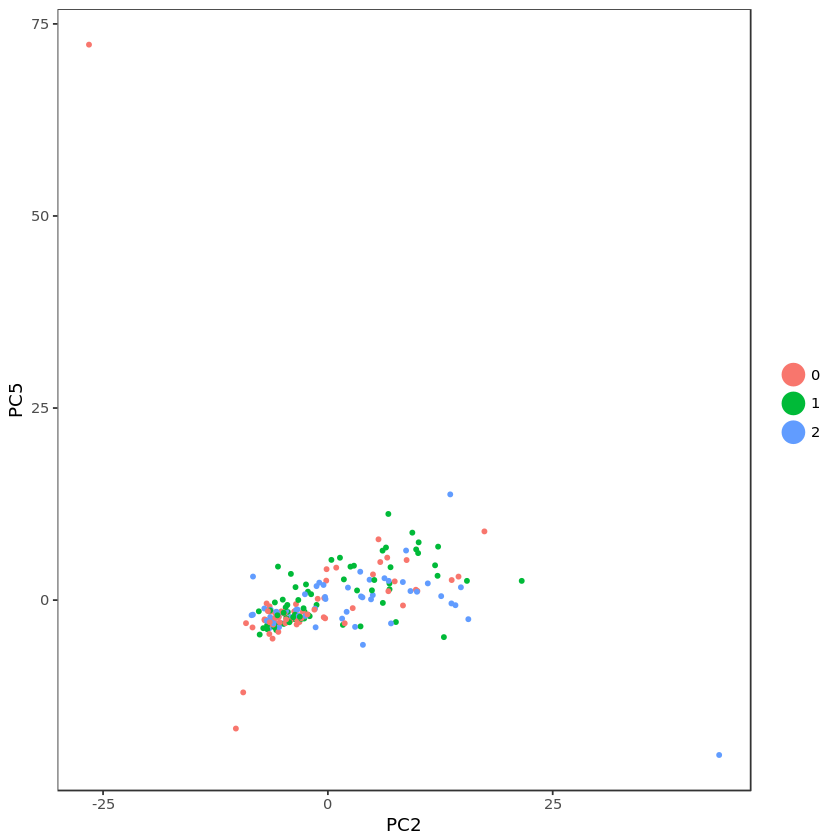

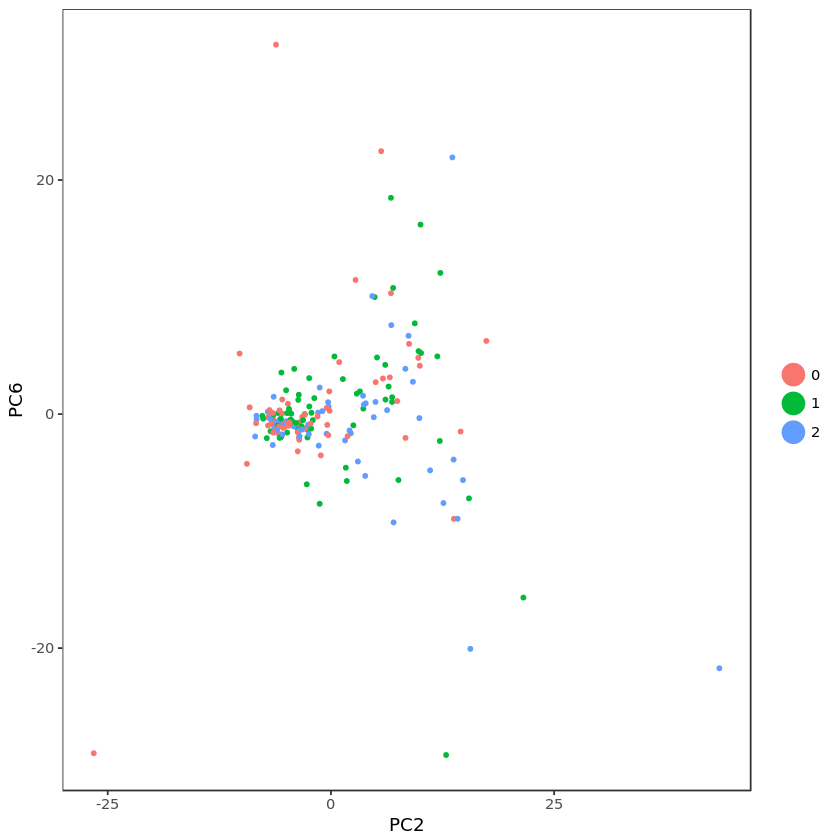

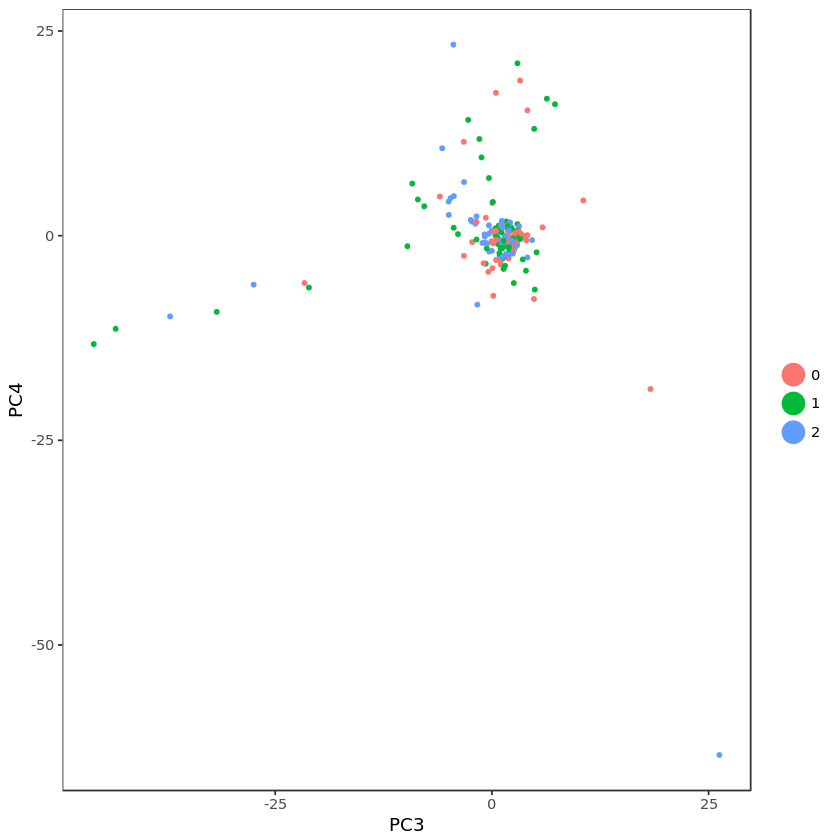

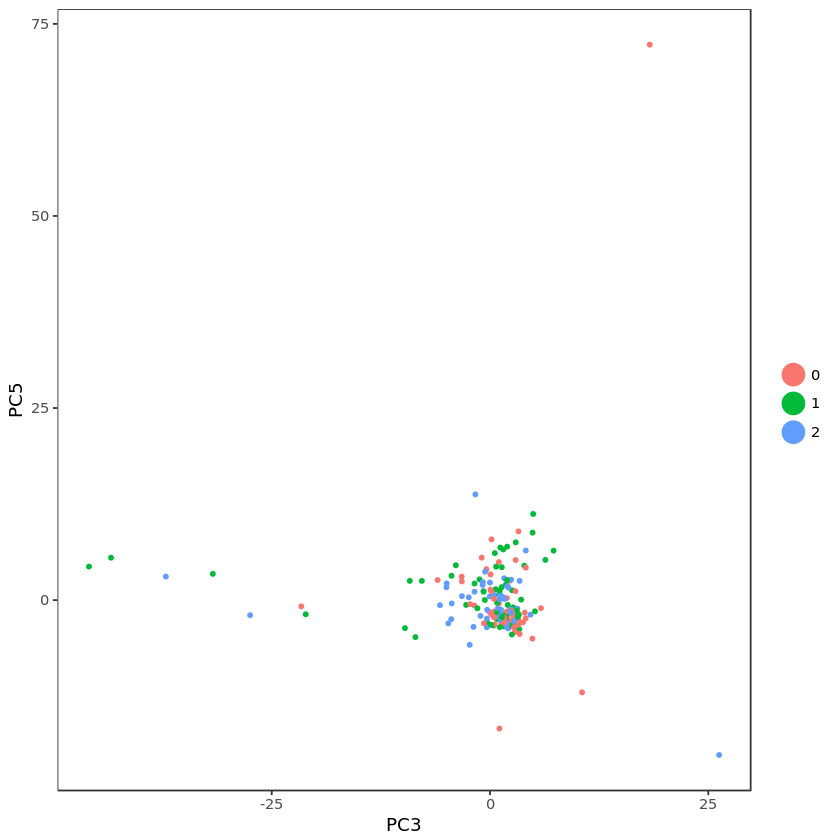

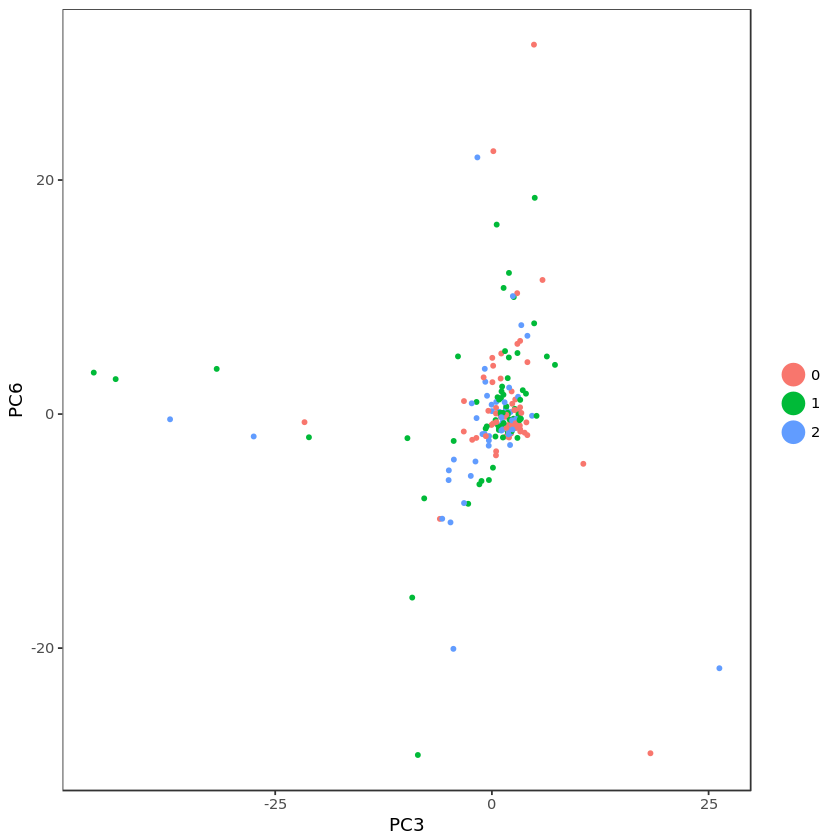

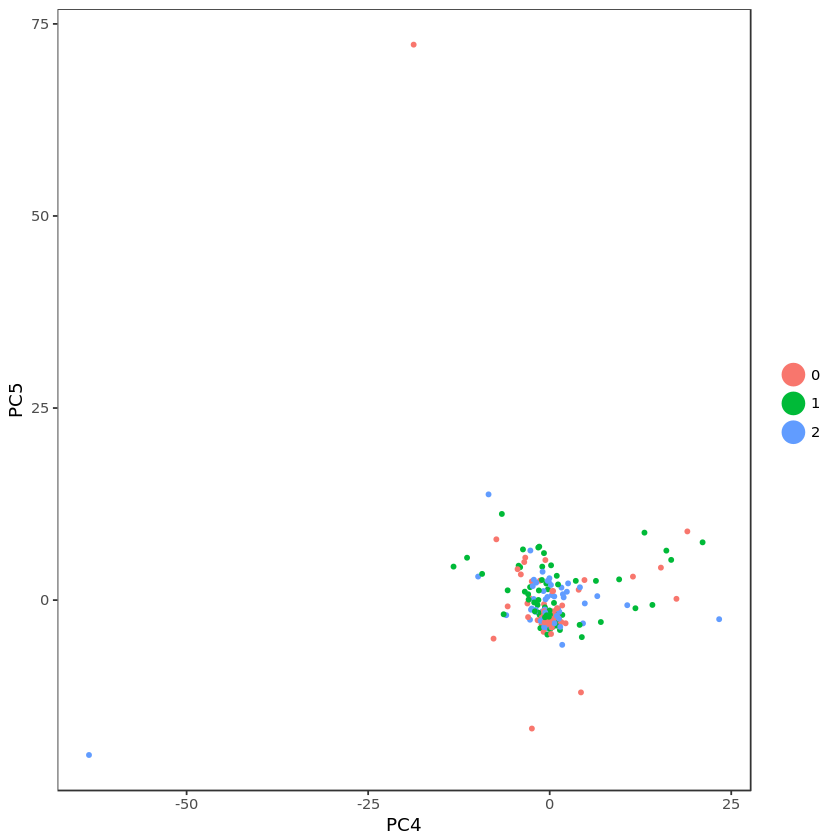

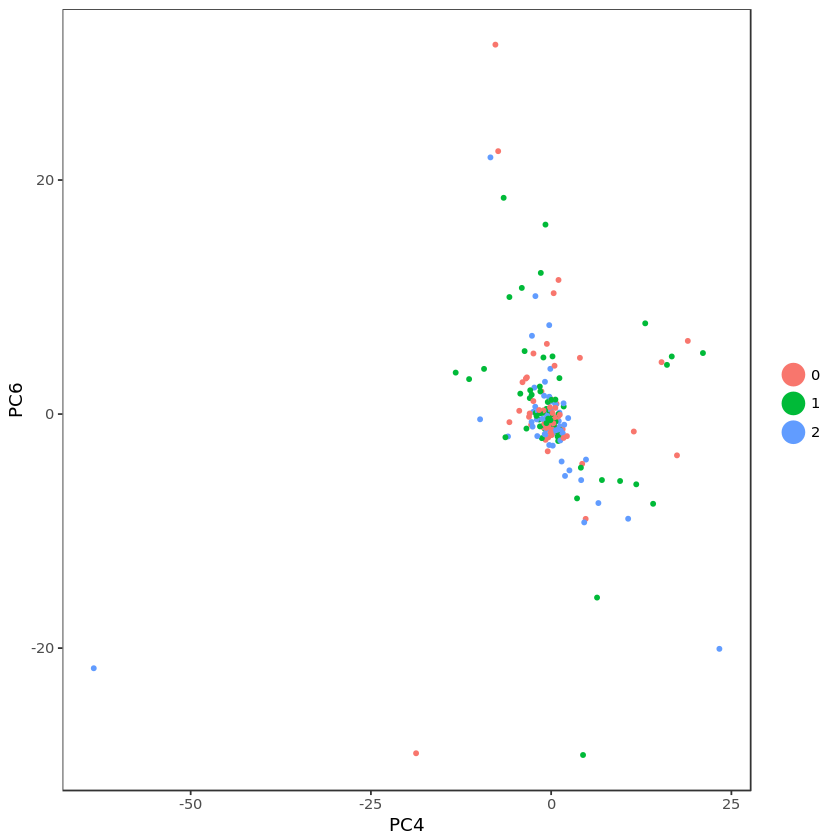

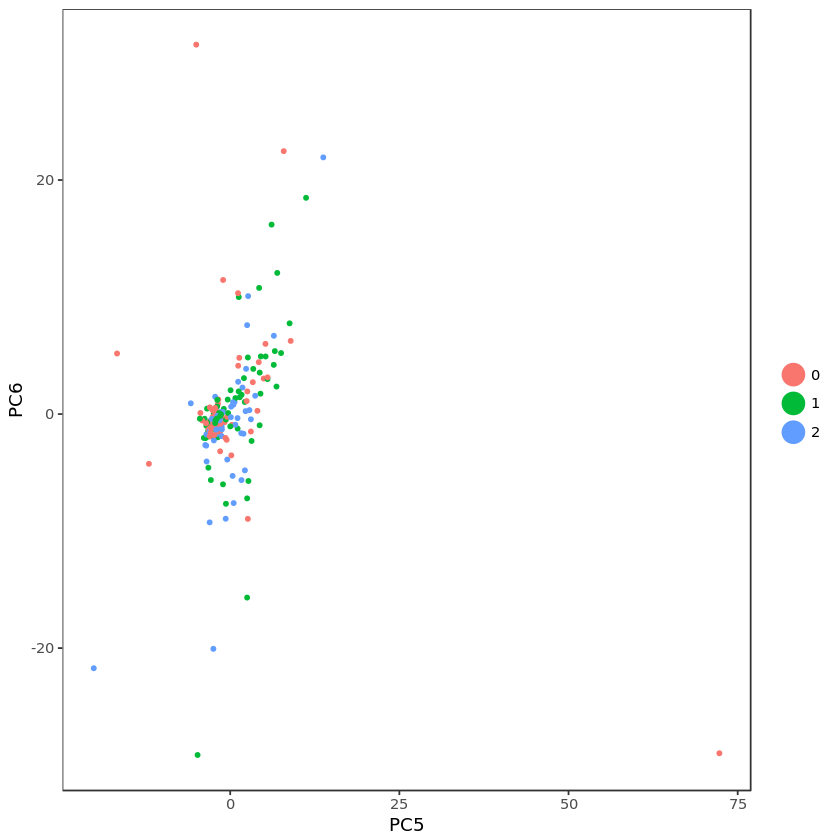

In [149]:
#par(mfrow = c(1, 3))
for (i in 1:5){
    for (j in (i+1):6){
        PCAPlot(object = seuset, dim.1 = i, dim.2 = j)
    }
}


In [17]:
PrintFindClustersParams(object = seuset)
table(seuset@ident)

Parameters used in latest FindClusters calculation run on: 2018-01-29 00:06:42
Resolution: 1
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8




 0  1  2  3 
65 59 49 17 

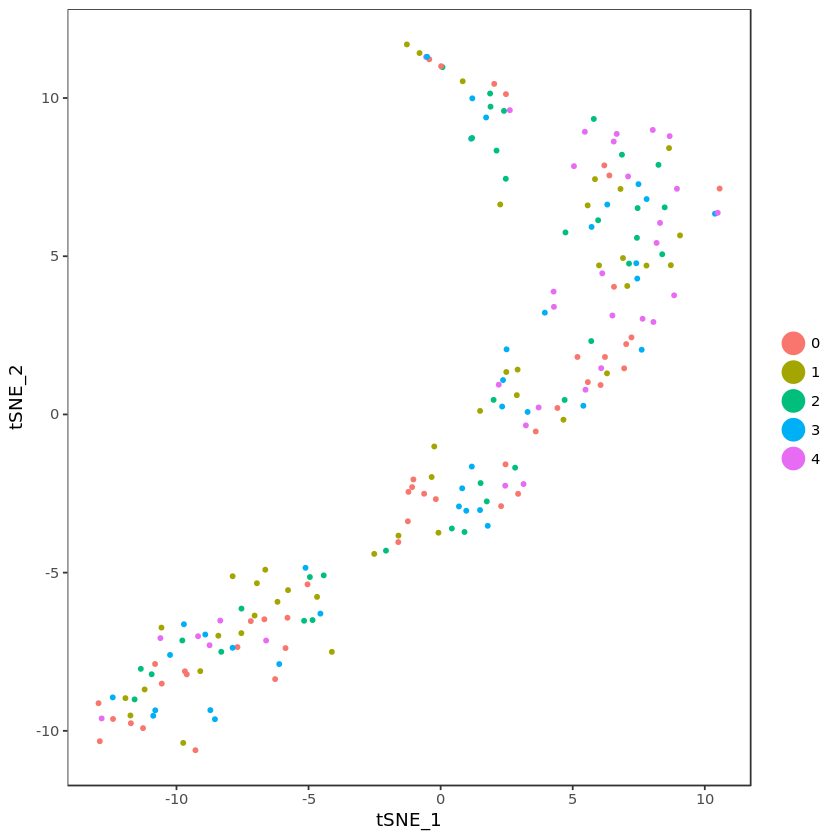

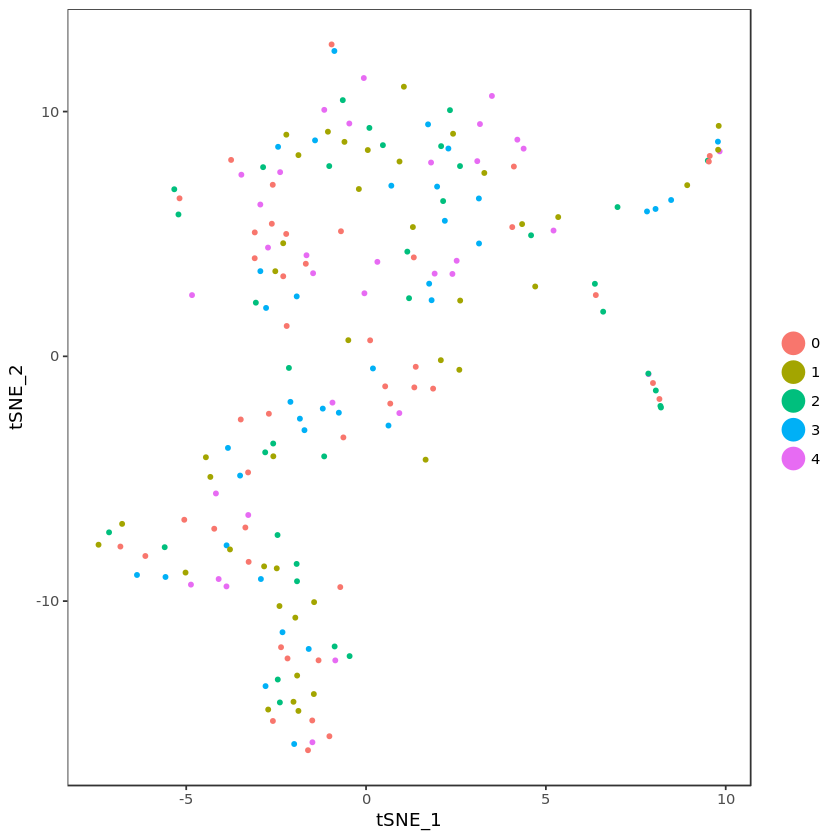

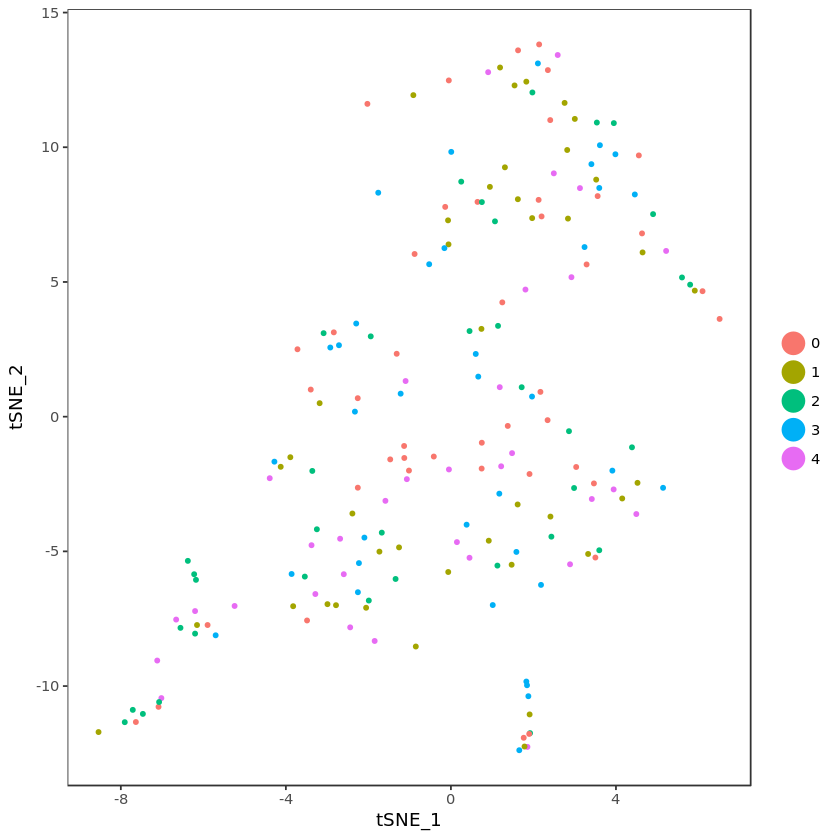

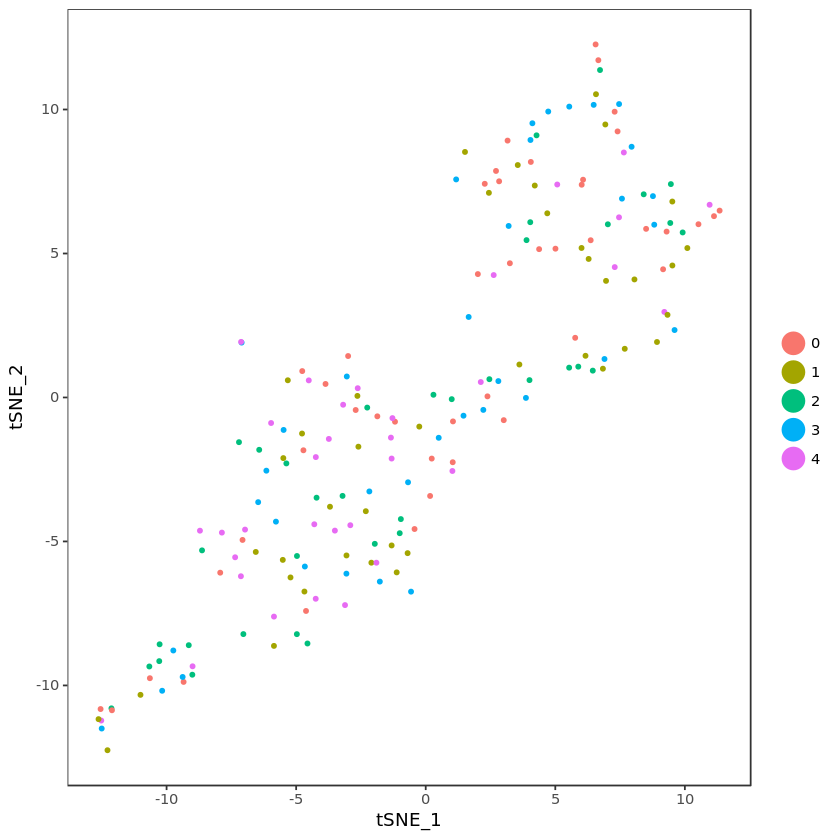

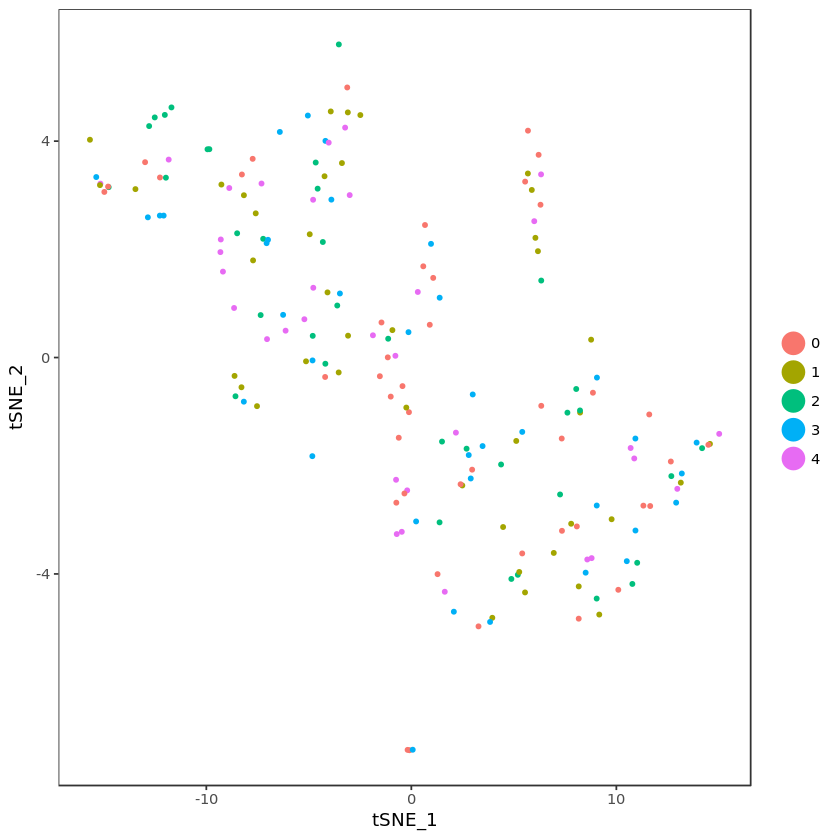

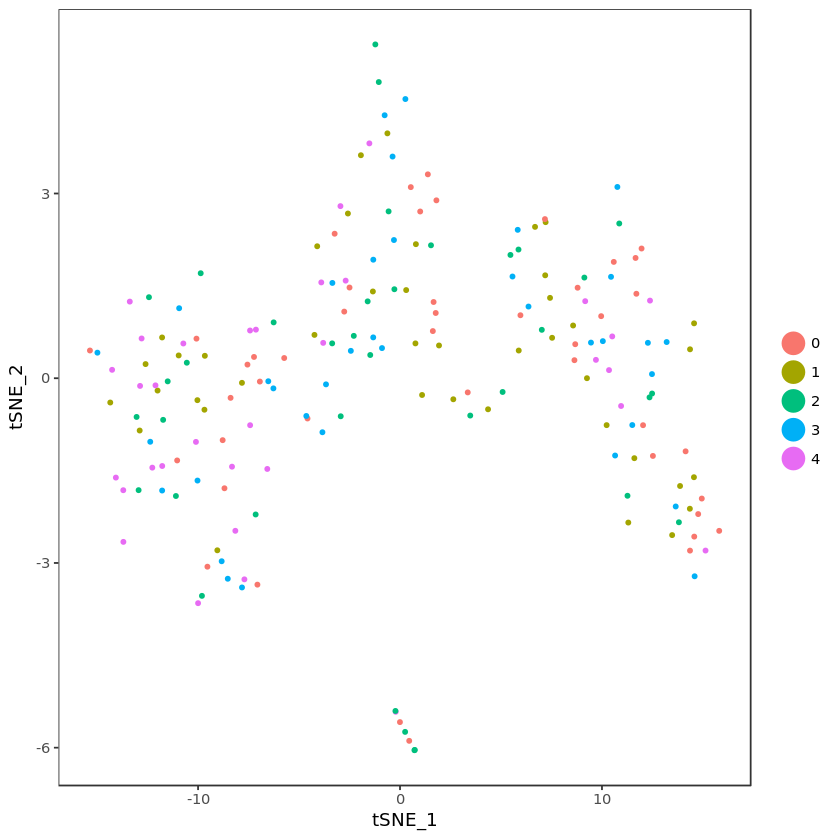

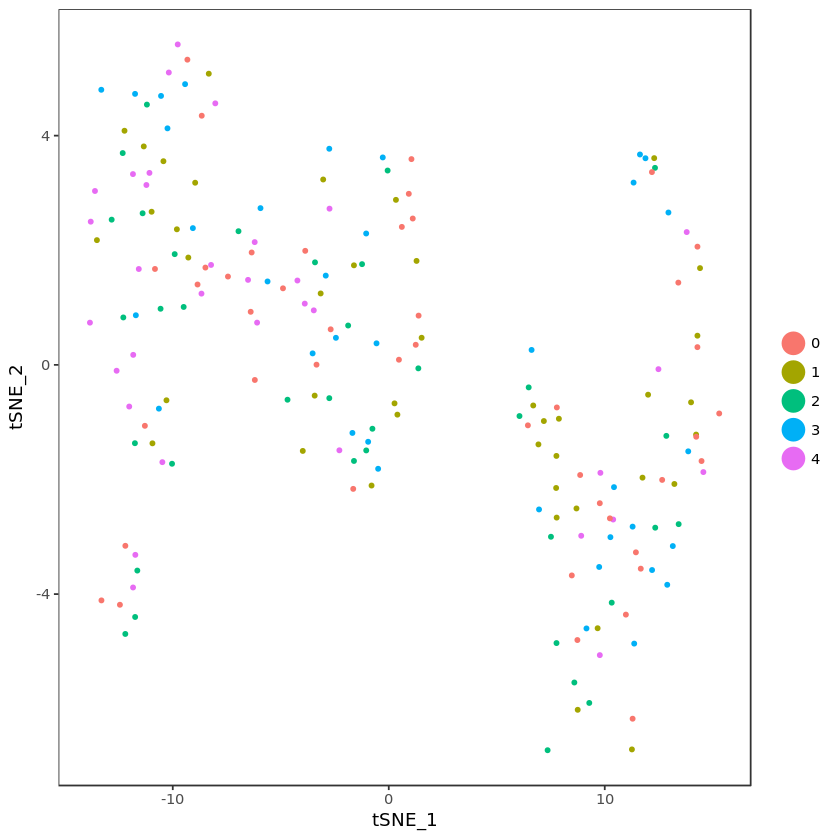

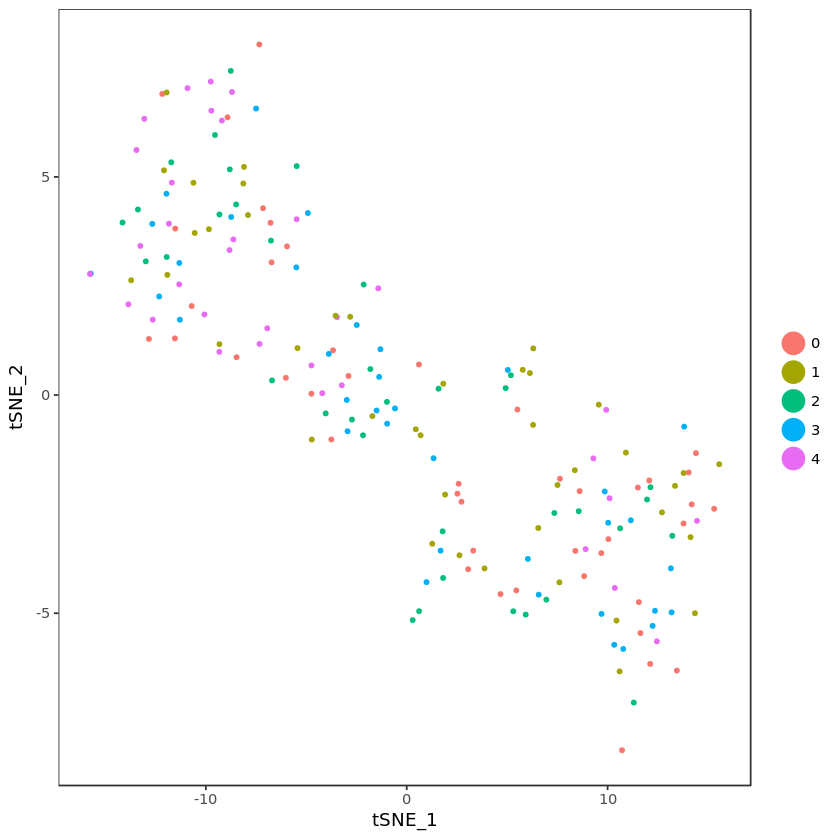

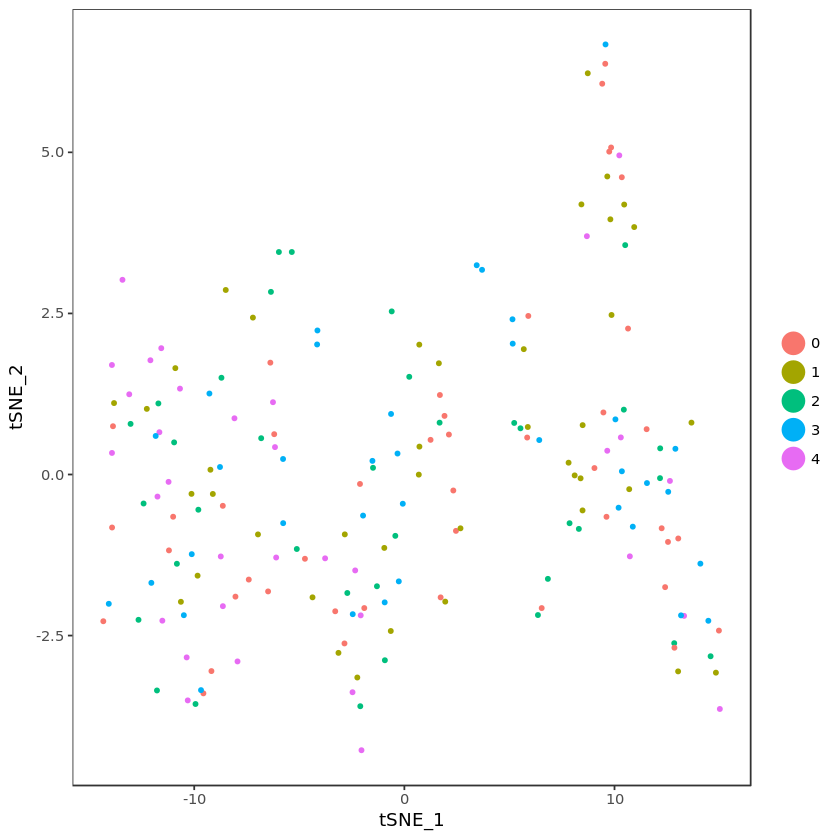

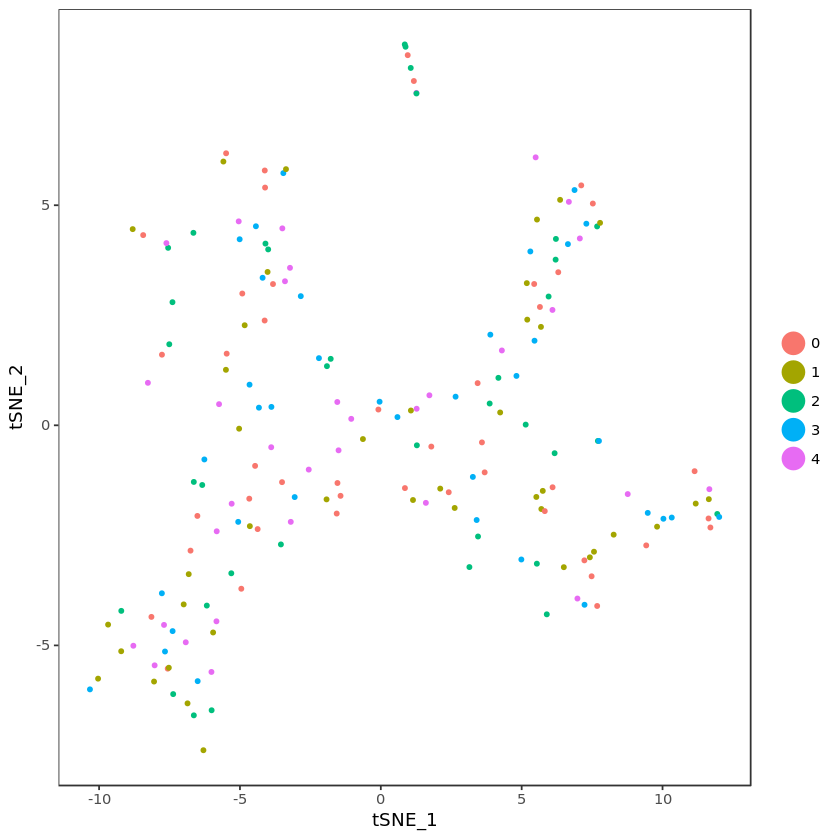

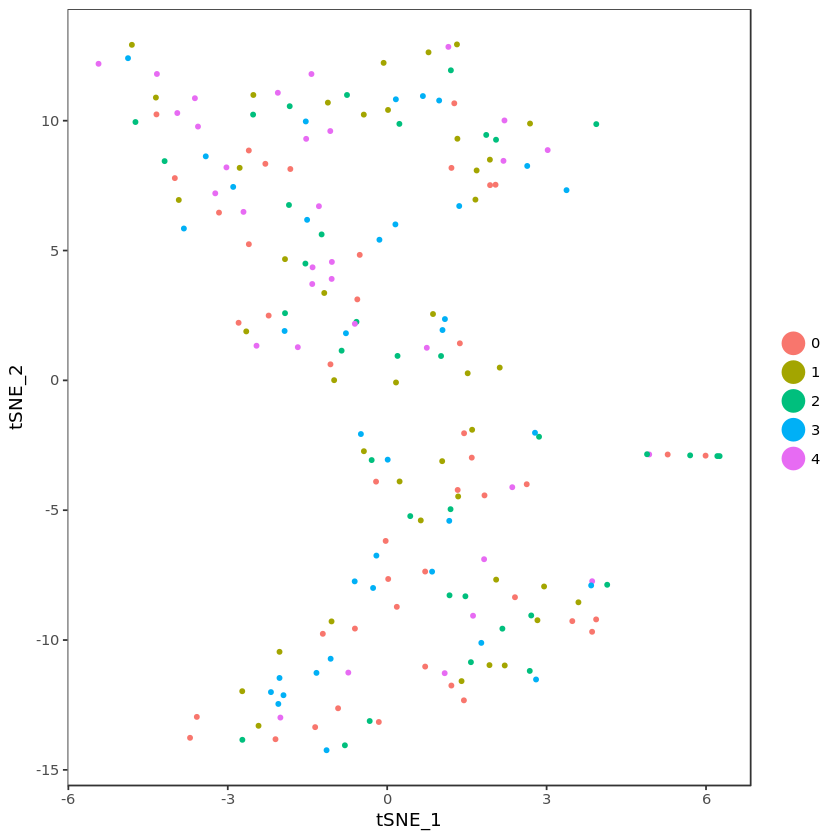

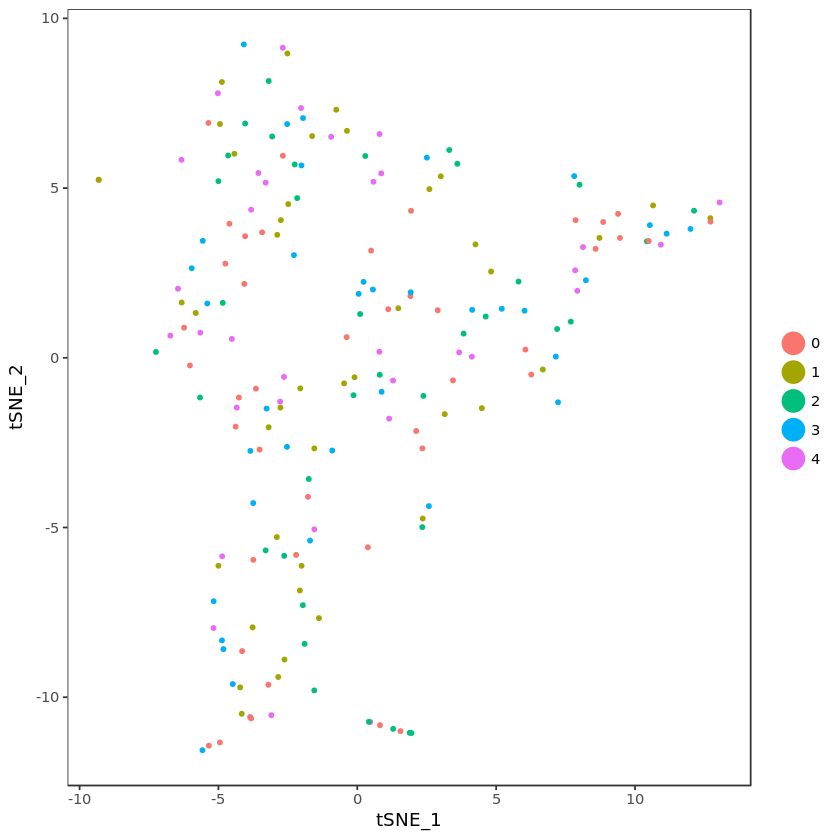

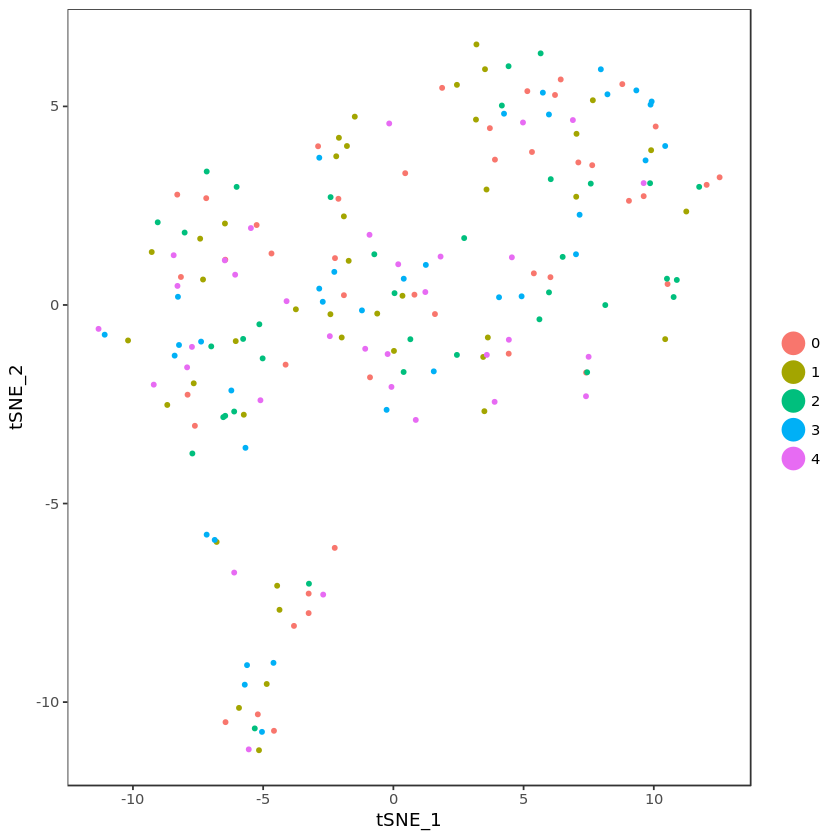

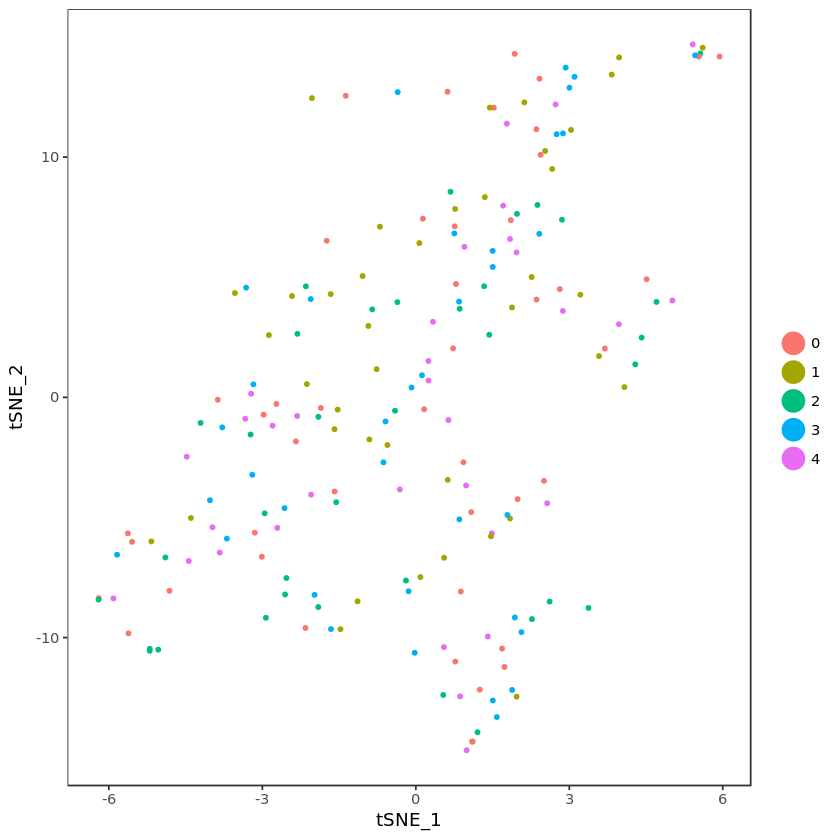

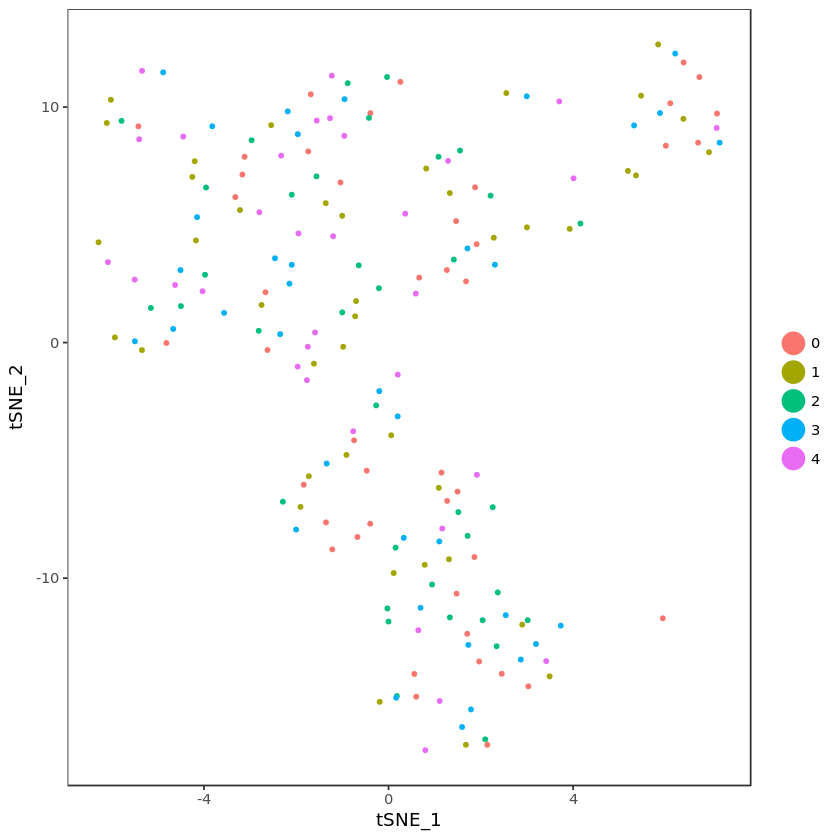

In [145]:
#par(mfrow = c(1, 3))
for (i in 1:5){
    for (j in (i+1):6){
        seuset <- RunTSNE(
            object = seuset,
            dims.use = c(i,j),
            do.fast = TRUE,
            seed.use = 11
        )
        TSNEPlot(object = seuset)        
    }
}





,p_val,avg_logFC,pct.1,pct.2,p_val_adj
ENSMUSG00000012848,1.967929e-13,0.6958114,1,0.971,2.945596e-09
ENSMUSG00000028234,2.635029e-11,0.7096745,1,0.956,3.944111e-07
ENSMUSG00000025967,2.224668e-10,0.5434580,1,0.964,3.329884e-06
ENSMUSG00000036305,2.690195e-10,0.7400005,1,0.949,4.026683e-06
ENSMUSG00000071415,5.795898e-10,0.5345314,1,0.905,8.675301e-06
ENSMUSG00000058443,5.831916e-10,0.5390056,1,0.978,8.729211e-06


DE for the 4 identified clusters


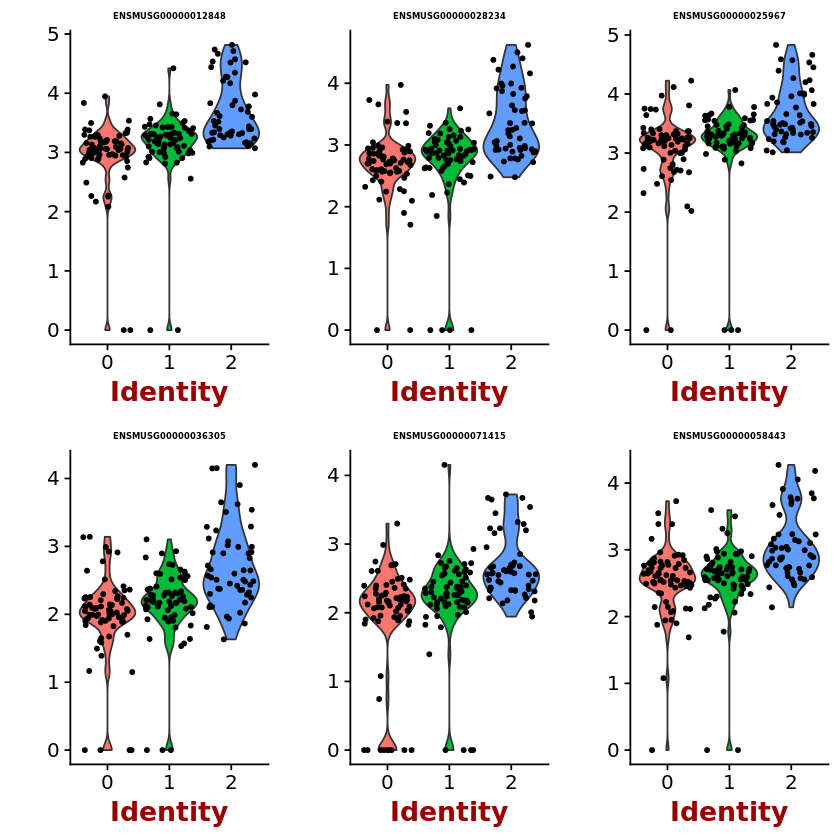

In [98]:
# Find Marker genes: define clusters via DE
markers2 <- FindMarkers(seuset, 2)
head(markers2,6)
VlnPlot(
    object = seuset, 
    features.plot = rownames(markers2)[1:6], 
    size.title.use = 5,
    remove.legend = FALSE,
    single.legend = TRUE
)
message("DE for the 4 identified clusters")

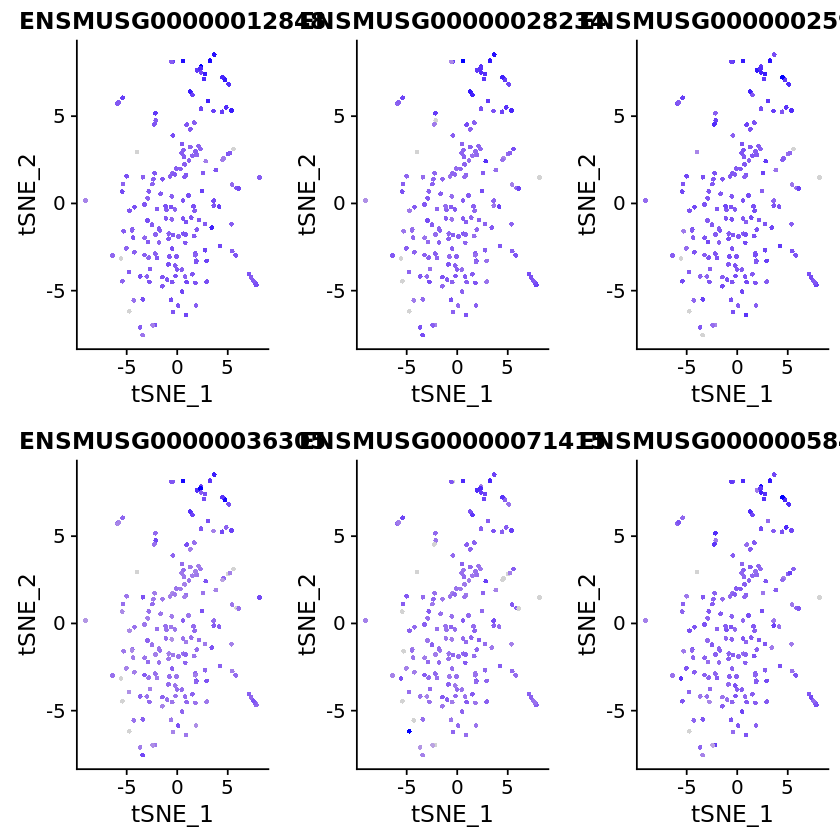

In [99]:
FeaturePlot(
    seuset, 
    head(rownames(markers2)), 
    cols.use = c("lightgrey", "blue"), 
    nCol = 3,
)

In [100]:
markers <- FindAllMarkers(
    object = seuset, 
    only.pos = TRUE, 
    min.pct = 0.25, 
    thresh.use = 0.25
)

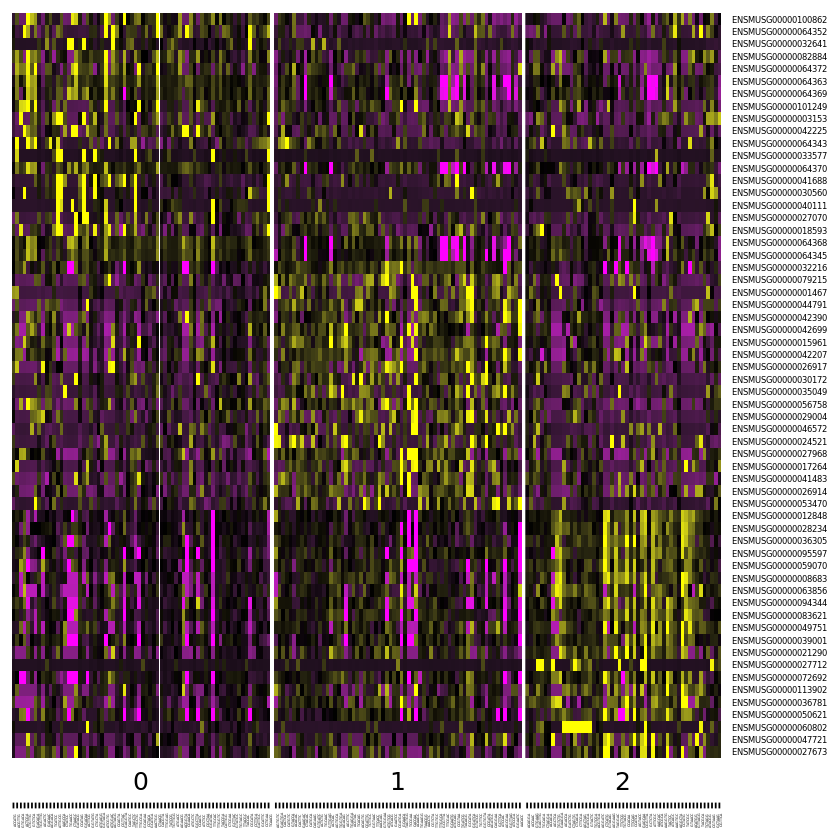

In [101]:
top20 <- markers %>% group_by(cluster) %>% top_n(20, avg_logFC)
DoHeatmap(
    object = seuset, 
    genes.use = top20$gene, 
    slim.col.label = FALSE, 
    remove.key = TRUE,
    cex.row = 5,
    cex.col = 2    
)

In [37]:
str(seuset)

Formal class 'seurat' [package "Seurat"] with 20 slots
  ..@ raw.data    : int [1:14968, 1:190] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:14968] "ENSMUSG00000000001" "ENSMUSG00000000028" "ENSMUSG00000000031" "ENSMUSG00000000037" ...
  .. .. ..$ : chr [1:190] "AGTGTC" "ACCATG" "GAGTGA" "CACTCA" ...
  ..@ data        :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:811165] 10 13 26 34 47 55 56 59 64 65 ...
  .. .. ..@ p       : int [1:191] 0 1565 7921 13109 17032 23046 30022 36173 39794 42022 ...
  .. .. ..@ Dim     : int [1:2] 14968 190
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:14968] "ENSMUSG00000000001" "ENSMUSG00000000028" "ENSMUSG00000000031" "ENSMUSG00000000037" ...
  .. .. .. ..$ : chr [1:190] "AGTGTC" "ACCATG" "GAGTGA" "CACTCA" ...
  .. .. ..@ x       : num [1:811165] 1.49 1.49 2.06 1.49 1.49 ...
  .. .. ..@ factors : list()
  ..@ scale.data  : num [1:14968, 1:190] -1.043 -0.394 -0.753 -0